In [2]:
%matplotlib inline

from collections import defaultdict
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('bmh')

import plots
plots.plot_width = 10

# plots to draw in do_plots_all()
all_plots = ['select_real', 'store_real',
             'obj_select_real', 'obj_last_insert_real',
             'obj_insert_real', 'obj_store',
             'src_select_real', 'src_insert_real',
             'fsrc_select_real', 'fsrc_insert_real']
whiskers = 4.


# Test with Cassandra on GCP with native partitioning

JIRA ticket: https://jira.lsstcorp.org/browse/DM-28522


In [3]:
data_files = [
    "data/DM-28522/apdb-gcp-6-20210127T220246.csv.gz",
    "data/DM-28522/apdb-gcp-6-20210128T061018.csv.gz",
    "data/DM-28522/apdb-gcp-6-20210128T064545.csv.gz",
    "data/DM-28522/apdb-gcp-6-20210128T162629.csv.gz",
    "data/DM-28522/apdb-gcp-6-20210129T030448.csv.gz",
    "data/DM-28522/apdb-gcp-6-20210129T142022.csv.gz",
]

In [4]:
frames = [plots._read_csv(file, filter_count=False)[0] for file in data_files]

In [5]:
df_cass = pd.concat(frames)
del frames
# strip visits that did not measure read time
df_cass = df_cass[(df_cass.index % 1000) < 100]

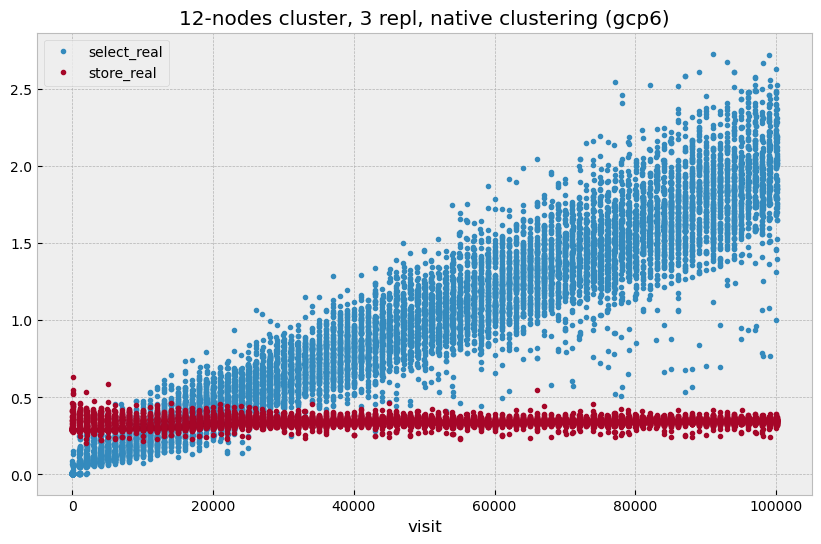

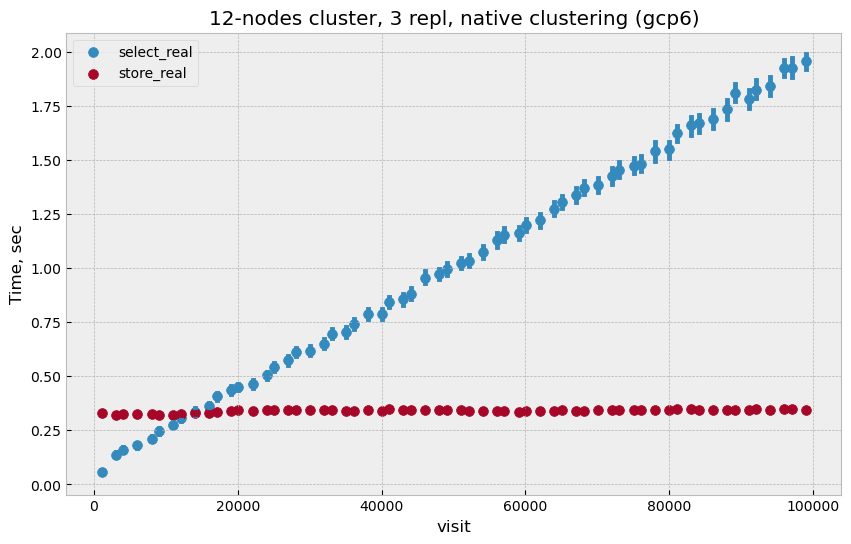

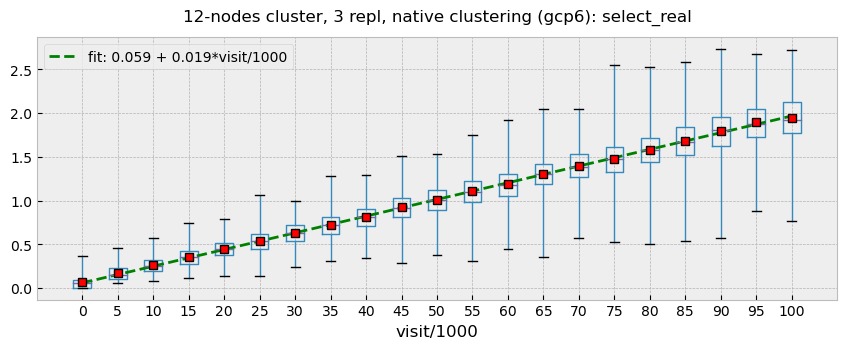

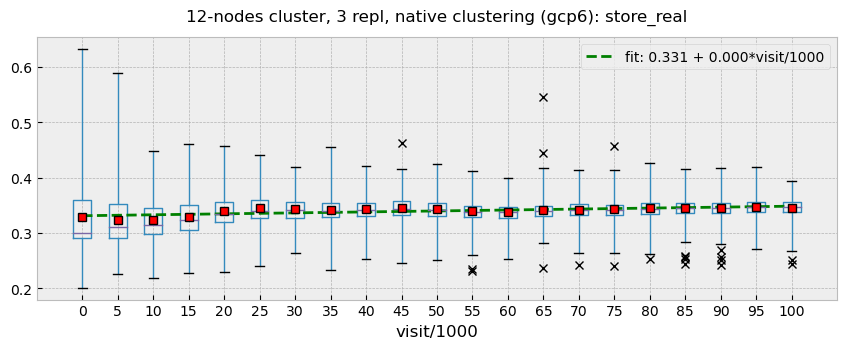

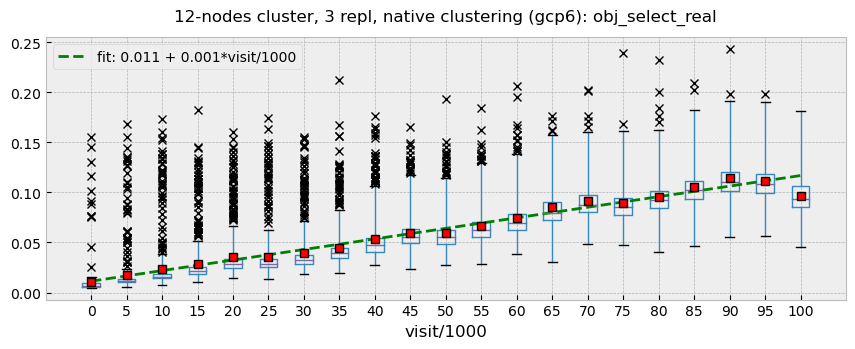

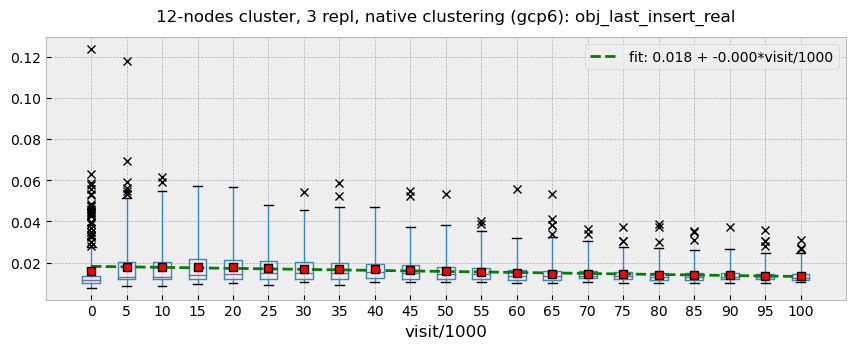

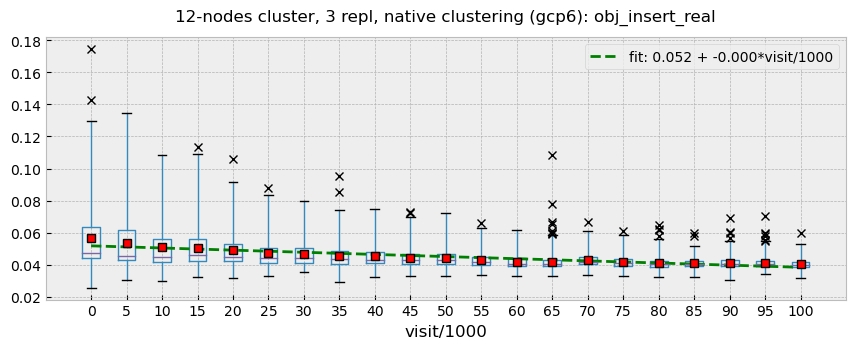

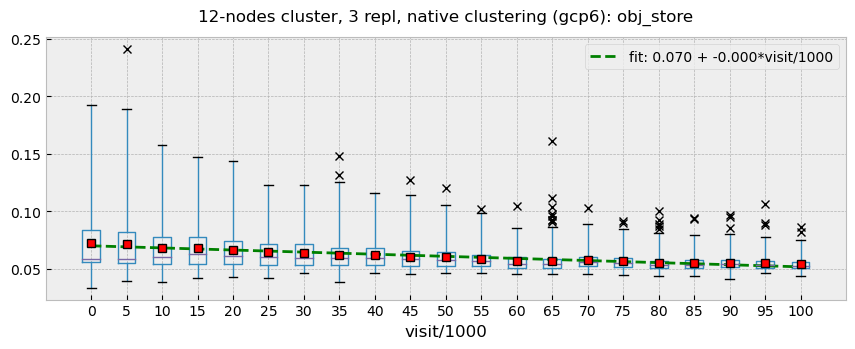

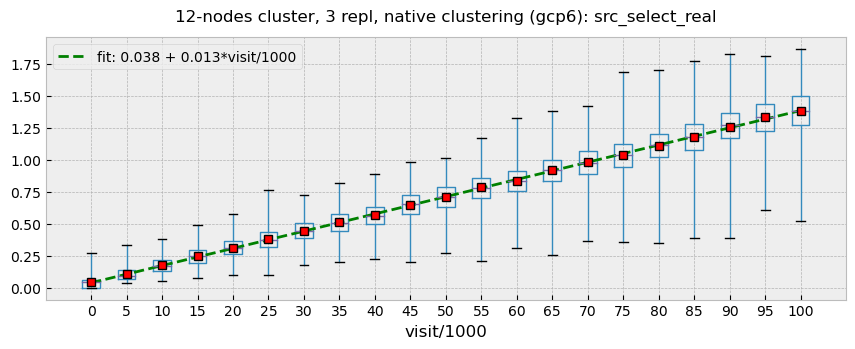

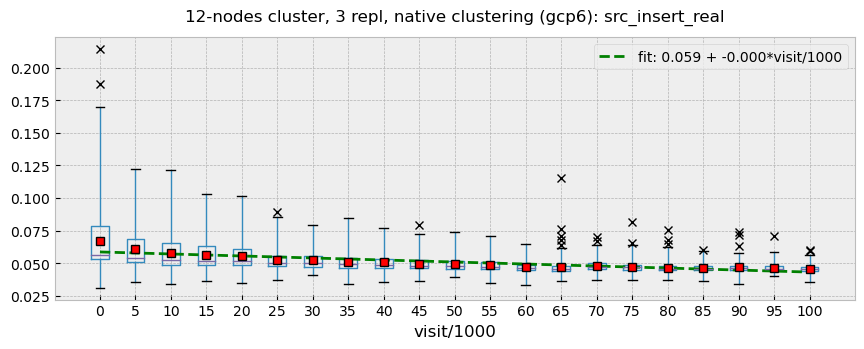

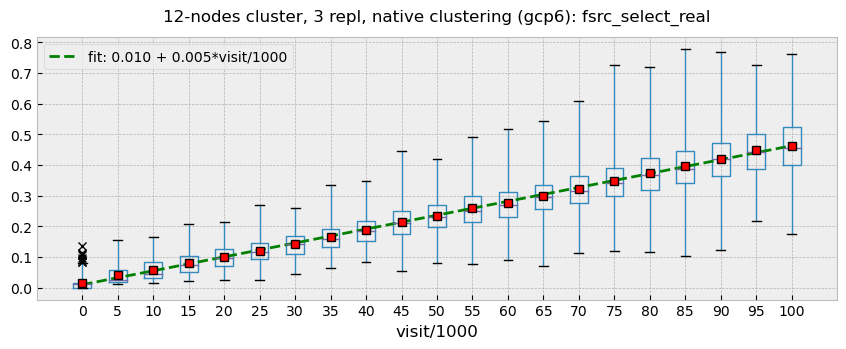

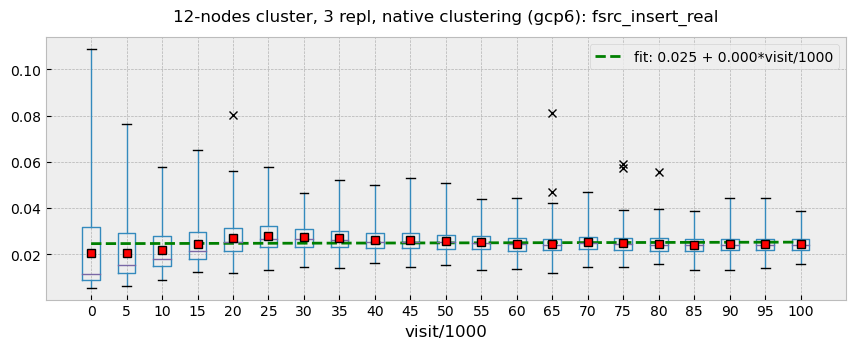

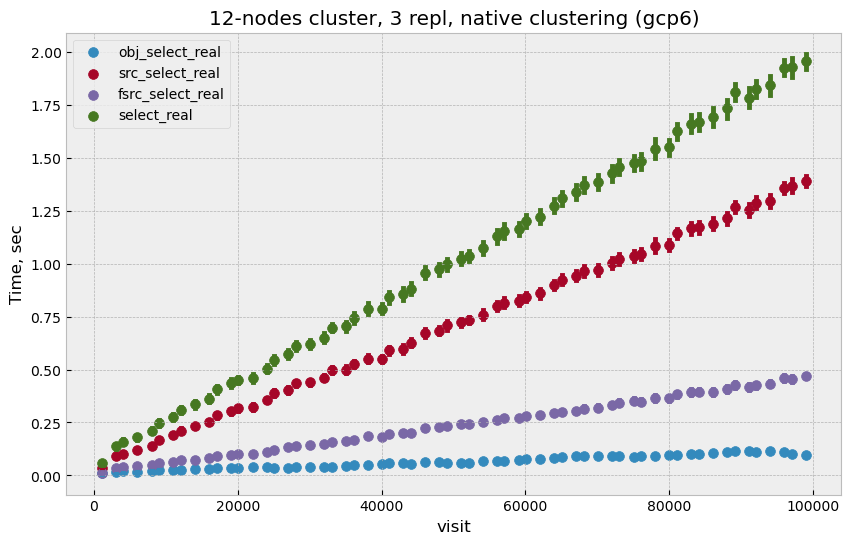

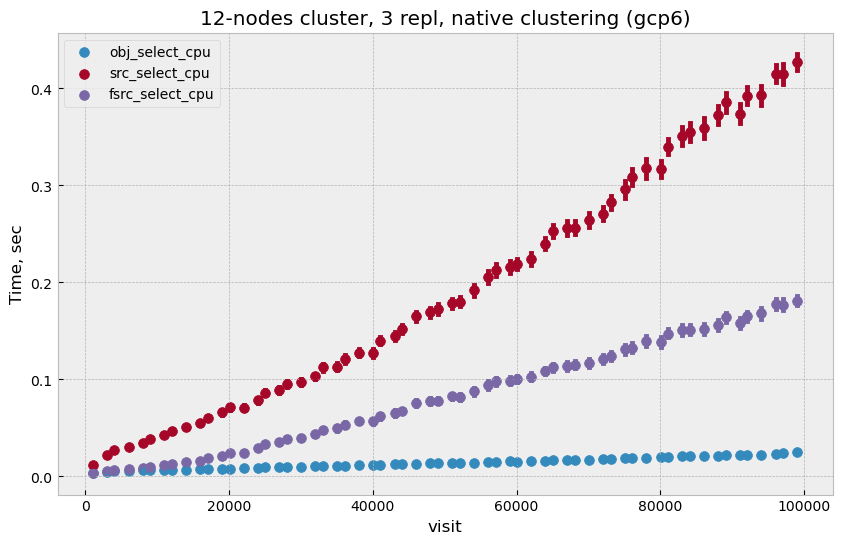

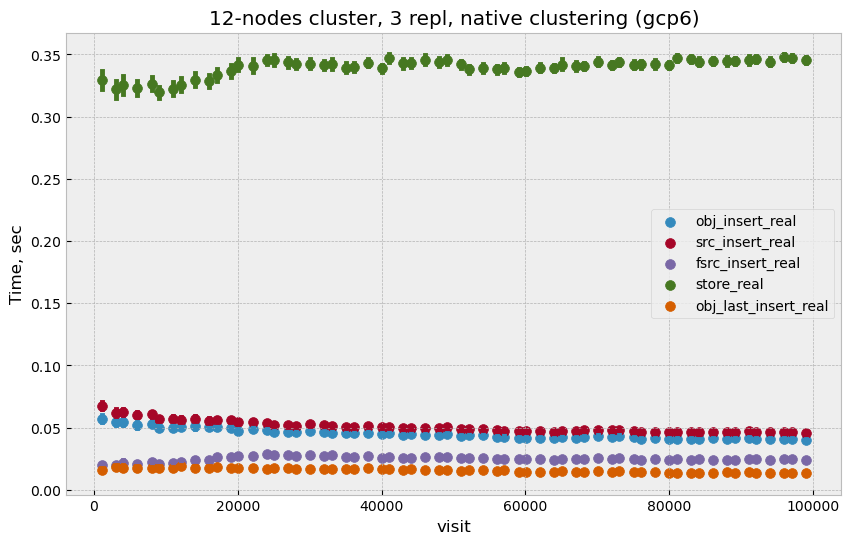

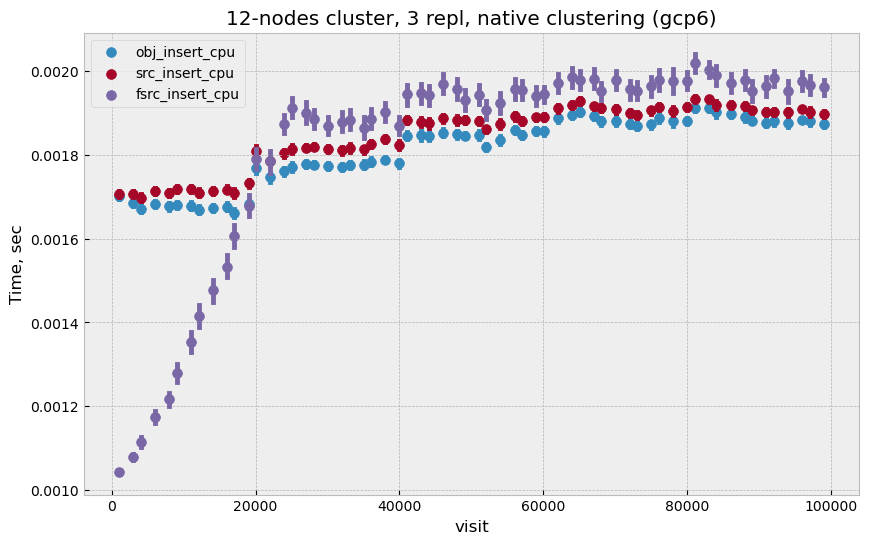

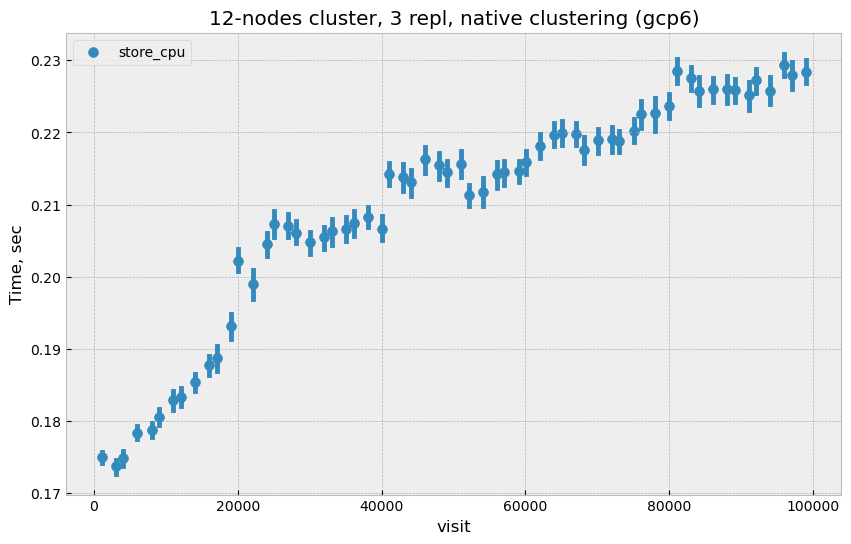

In [6]:
# fit_modes = dict(
#     store_real=None,
#     obj_last_insert_real=None,
#     src_insert_real=None,
#     fsrc_insert_real=None,
#     obj_insert_real=None,
#     src_insert_cpu=None,
#     fsrc_insert_cpu=None,
#     obj_insert_cpu=None,
#     store_cpu=None,
# )

title = "12-nodes cluster, 3 repl, native clustering (gcp6)"
plots.do_plots_all(df_cass, title, bin=5000, plots=all_plots, whis=whiskers, fit_mode=None, fit_nbins=62);

### Fit for first 100k visits

To compare to previous tests

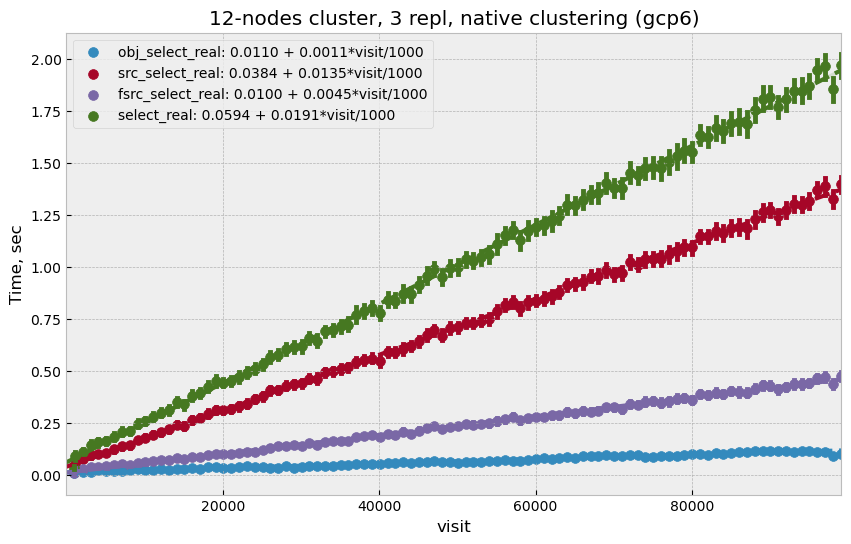

In [7]:
cols = ['obj_select_real', 'src_select_real', 'fsrc_select_real', 'select_real']
plots.plot_fit_times(df_cass[:9999], cols, fit_mode="poly", nbins=100, title=title);

## Test with query per partition (gcp7)

Previous test was done with a single query covering all partitions (`SELECT * from DiaSource WHERE apdb_part IN (...) AND apdb_time_part IN (...)`) which was diffrent from table-per-partition where we need to run mulpiple queries, one query per time table (`SELECT * from DiaSource_NNN WHERE apdb_part IN (...)`). This series of test was using two configurations:
- one query per time partition, similar to table-per-partition (`SELECT * from DiaSource WHERE apdb_part IN (...) AND apdb_time_part = NNN`)
- one query per both time and spatial partition (`SELECT * from DiaSource WHERE apdb_part = MMM AND apdb_time_part = NNN`)

Latter case is sort of extreme and makes large number of queries (about 250 queries per visit for each source and forced source table).

In [8]:
data_files = [
    "data/DM-28522/apdb-gcp-7-20210201T194937.csv.gz",
    "data/DM-28522/apdb-gcp-7-20210202T043317.csv.gz",
    "data/DM-28522/apdb-gcp-7-20210202T144813.csv.gz",
    "data/DM-28522/apdb-gcp-7-20210202T165421.csv.gz",
    "data/DM-28522/apdb-gcp-7-20210202T231213.csv.gz",
    "data/DM-28522/apdb-gcp-7-20210203T043711.csv.gz",
    "data/DM-28522/apdb-gcp-7-20210203T175733.csv.gz",
    "data/DM-28522/apdb-gcp-7-20210204T010604.csv.gz",
    "data/DM-28522/apdb-gcp-7-20210204T144509.csv.gz",
]

In [9]:
frames = [plots._read_csv(file, filter_count=False)[0] for file in data_files]

In [10]:
df_cass = pd.concat(frames)
del frames
# strip visits that did not measure read time
df_cass = df_cass[(df_cass.index % 1000) < 100]

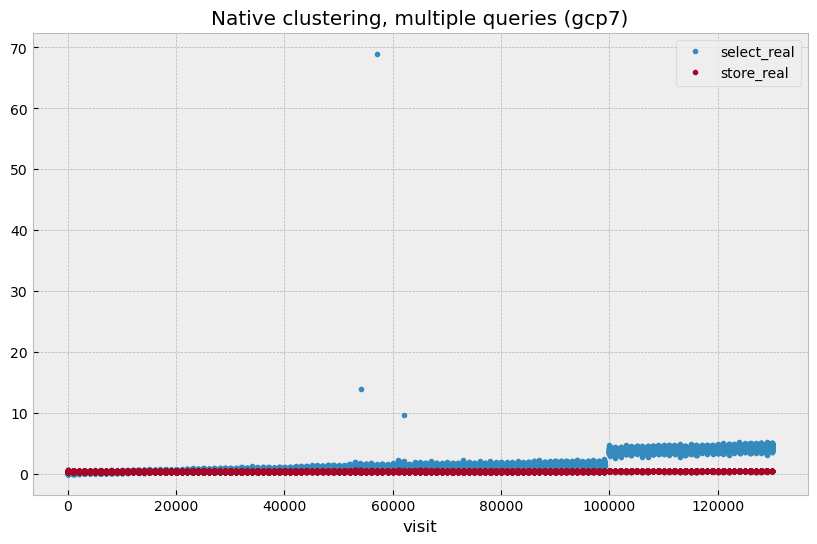

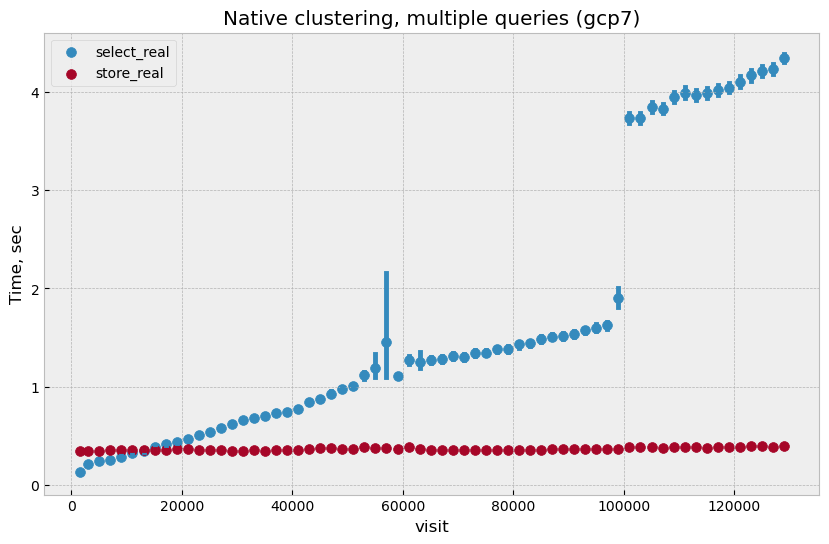

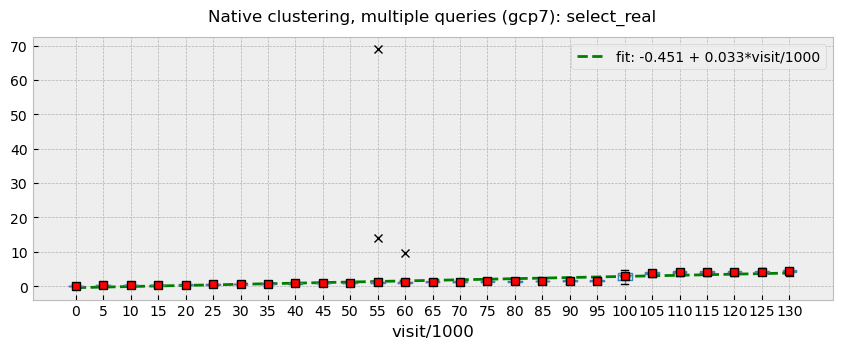

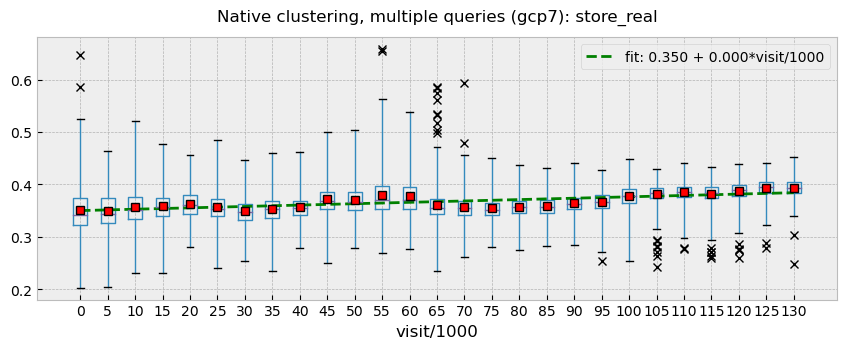

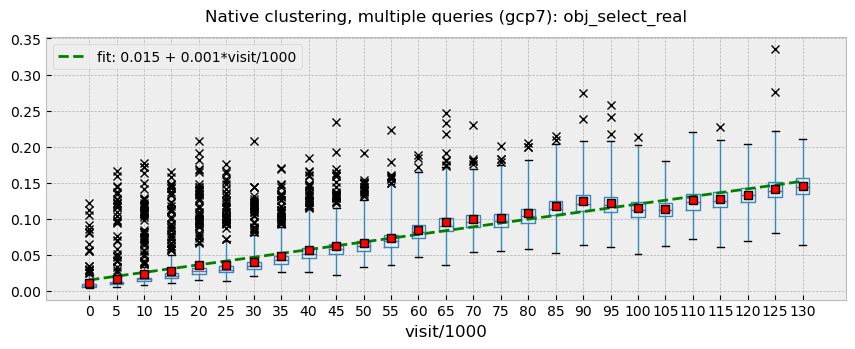

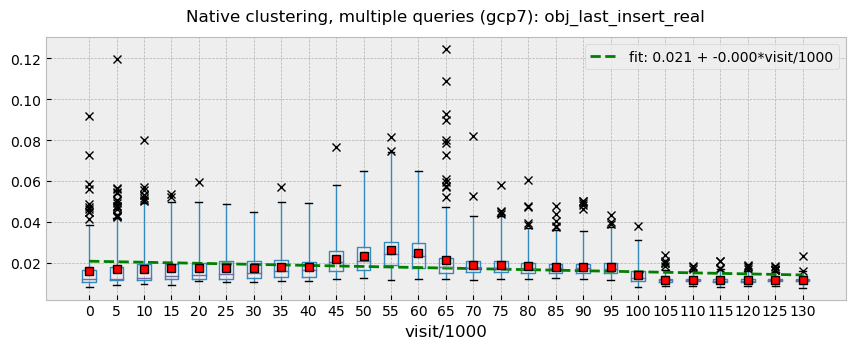

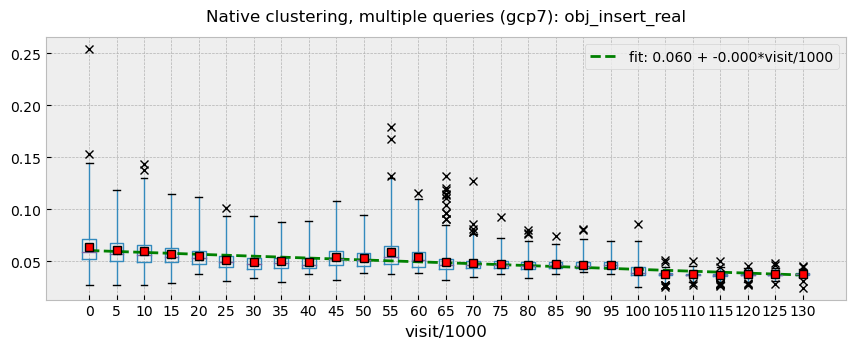

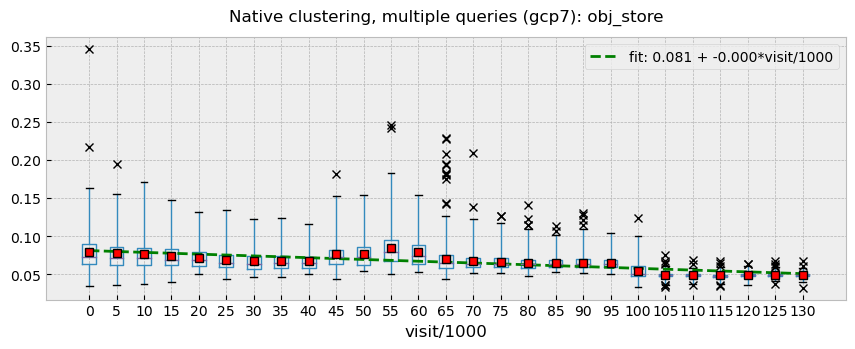

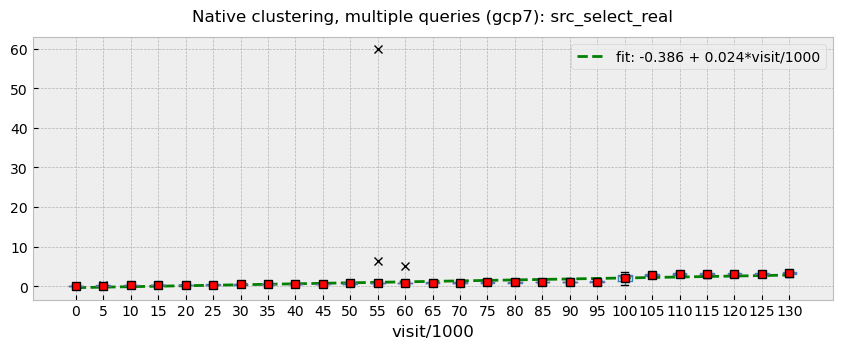

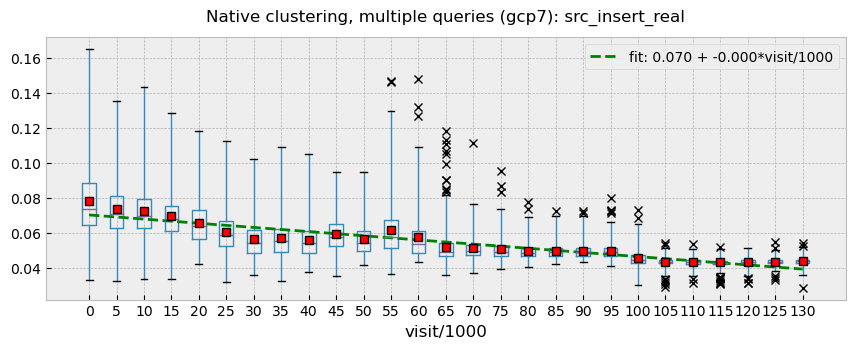

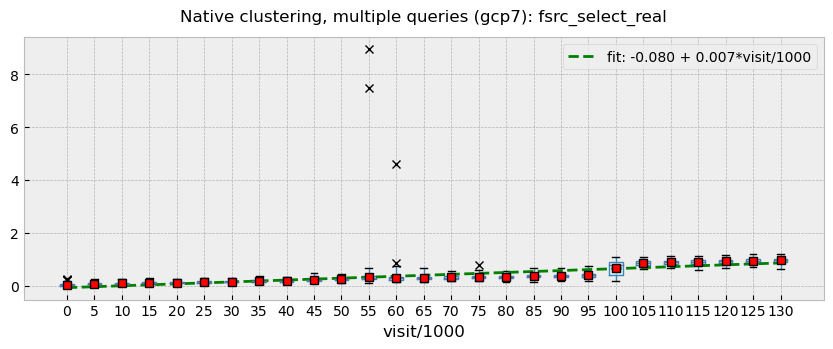

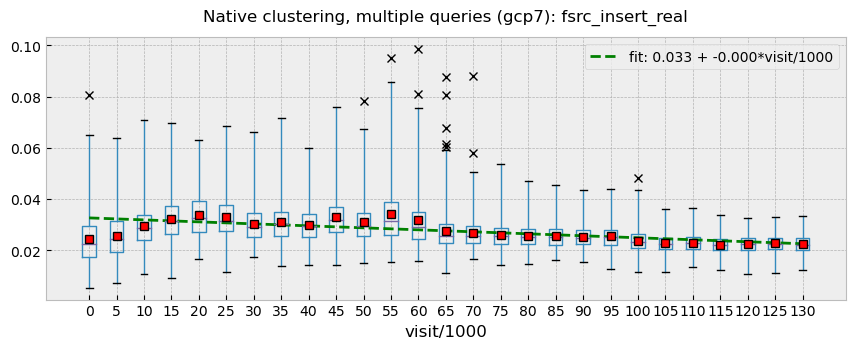

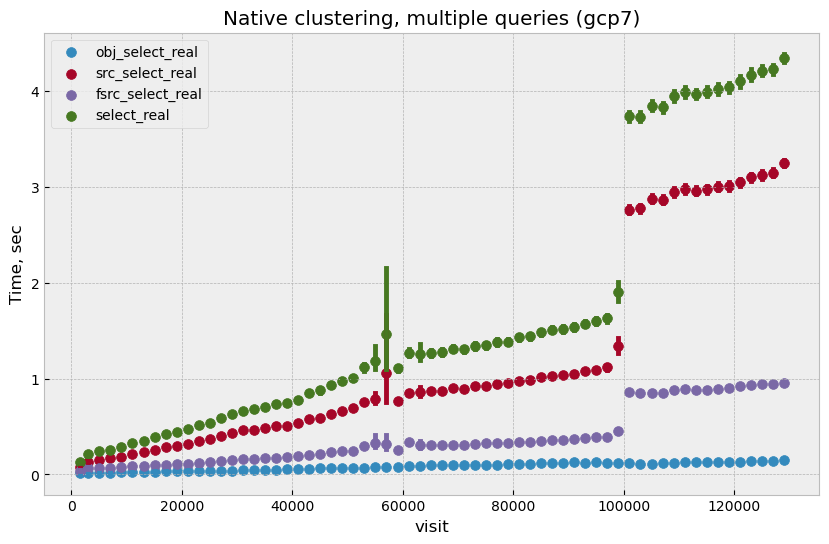

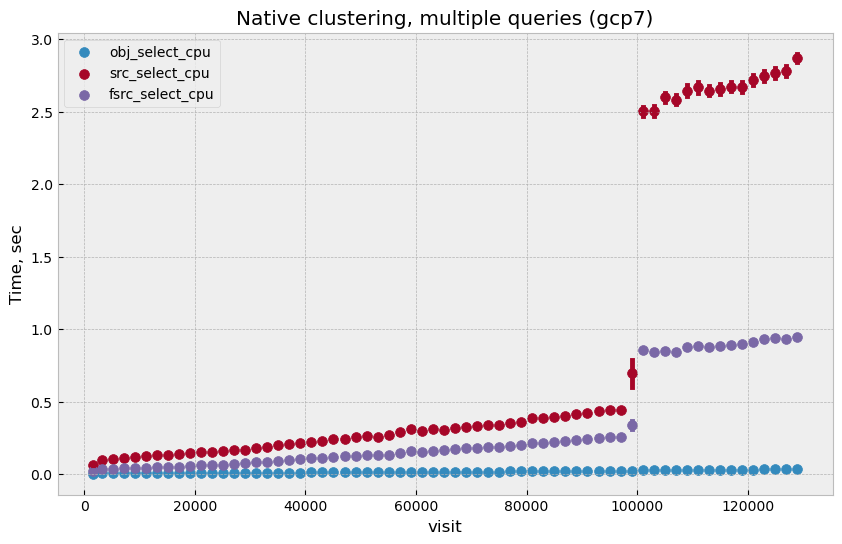

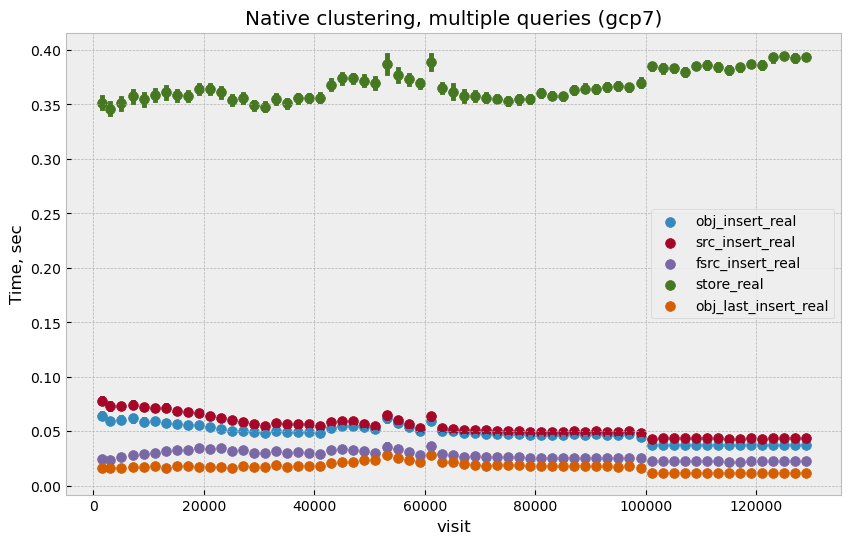

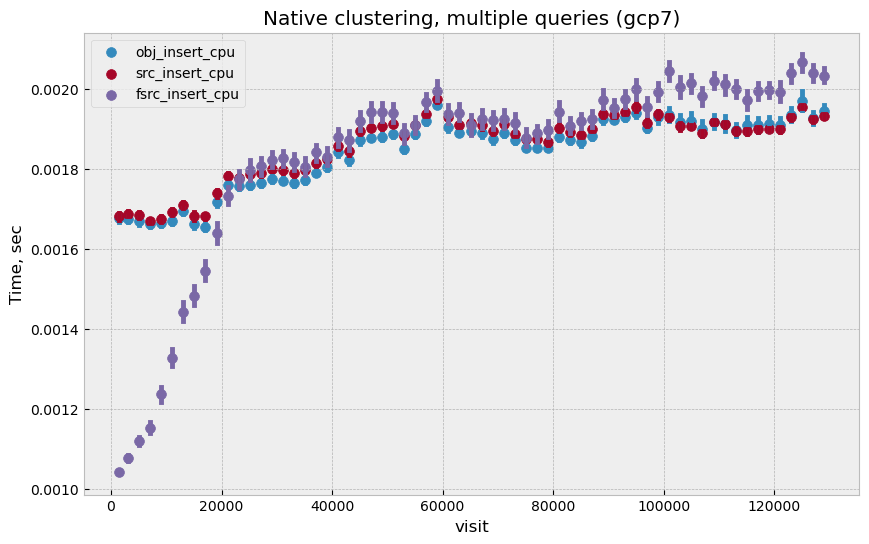

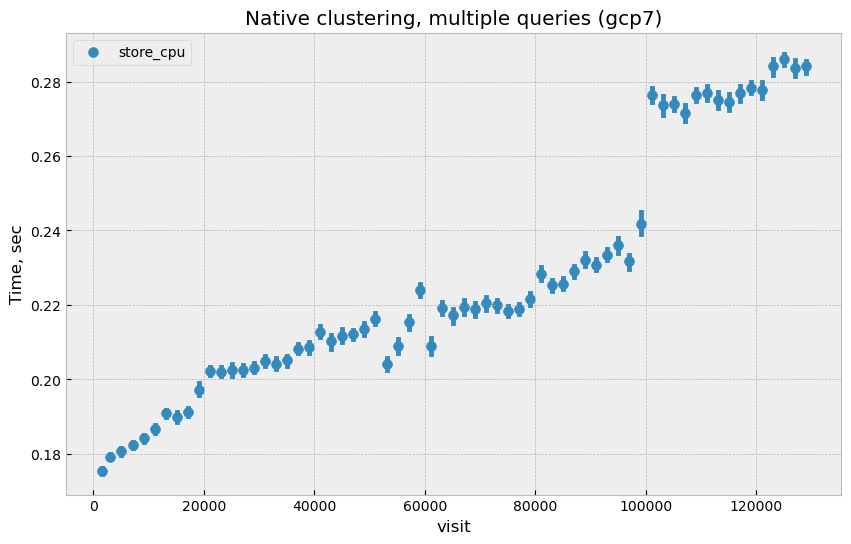

In [11]:
title = "Native clustering, multiple queries (gcp7)"
plots.do_plots_all(df_cass, title, bin=5000, plots=all_plots, whis=whiskers, fit_mode=None, fit_nbins=65);

### Real minus CPU time

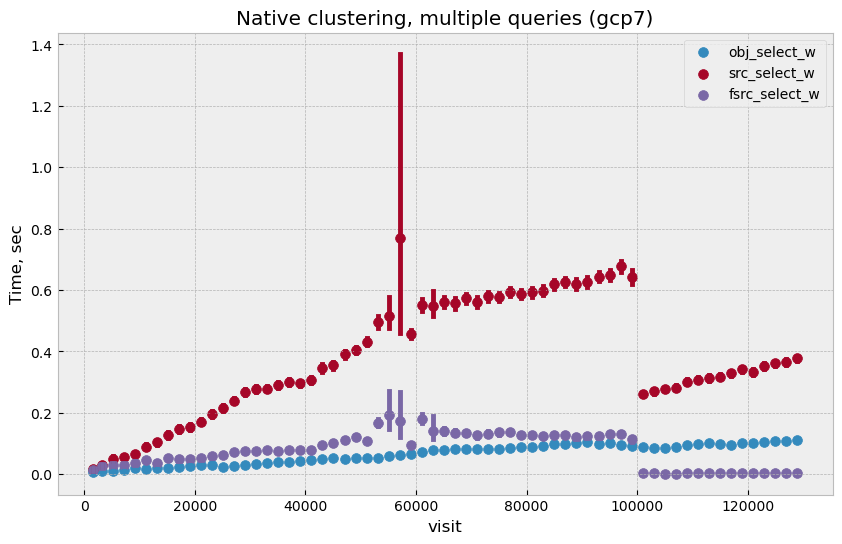

In [12]:
df_cass["obj_select_w"] = df_cass["obj_select_real"] - df_cass["obj_select_cpu"]
df_cass["src_select_w"] = df_cass["src_select_real"] - df_cass["src_select_cpu"]
df_cass["fsrc_select_w"] = df_cass["fsrc_select_real"] - df_cass["fsrc_select_cpu"]
plots.plot_fit_times(df_cass, ["obj_select_w", "src_select_w", "fsrc_select_w"],
                     title=title, fit_mode=None, nbins=65);

### Real time fit for first 100k events

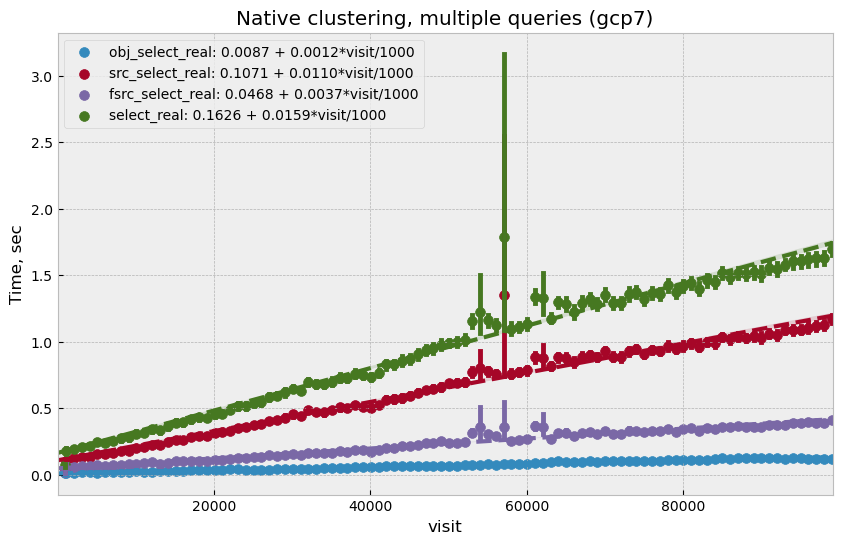

In [13]:
cols = ['obj_select_real', 'src_select_real', 'fsrc_select_real', 'select_real']
plots.plot_fit_times(df_cass[:9999], cols, fit_mode="poly", nbins=100, title=title);

## Re-testing with updated conversion (gcp-8)

Conversion of query results to panda has been re-implemented, instead of converting each individual query result to pandas and then merging the results I now concatenate all result rows in one list and convert that in one call to pandas.

In [14]:
data_files = [
    "data/DM-28522/apdb-gcp-8-20210209T000211.csv.gz",
    "data/DM-28522/apdb-gcp-8-20210209T083214.csv.gz",
    "data/DM-28522/apdb-gcp-8-20210209T182228.csv.gz",
    "data/DM-28522/apdb-gcp-8-20210210T050805.csv.gz",
    "data/DM-28522/apdb-gcp-8-20210210T165645.csv.gz",
]

In [15]:
frames = [plots._read_csv(file, filter_count=False)[0] for file in data_files]

In [16]:
df_cass = pd.concat(frames)
del frames
# strip visits that did not measure read time
df_cass = df_cass[(df_cass.index % 1000) < 100]

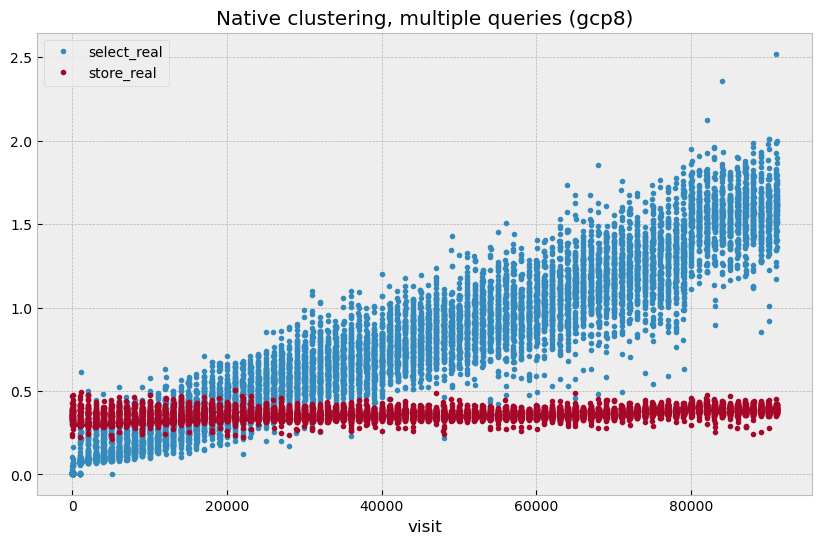

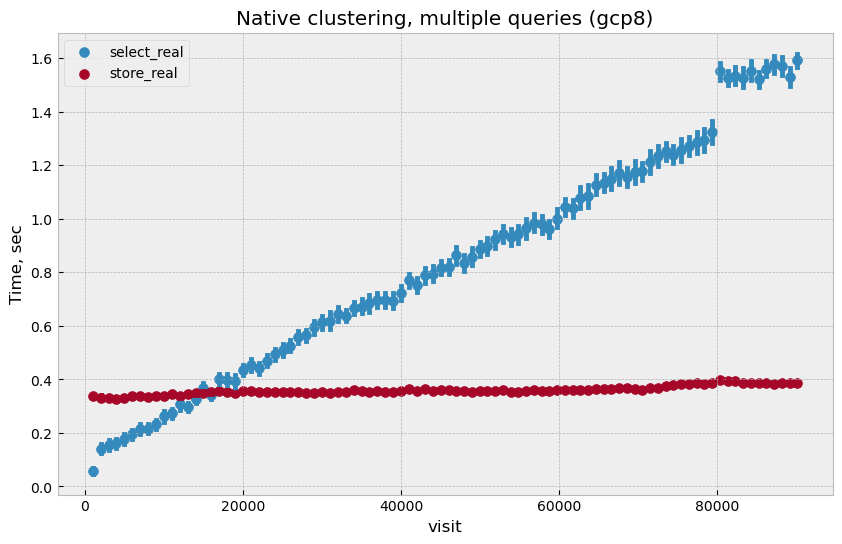

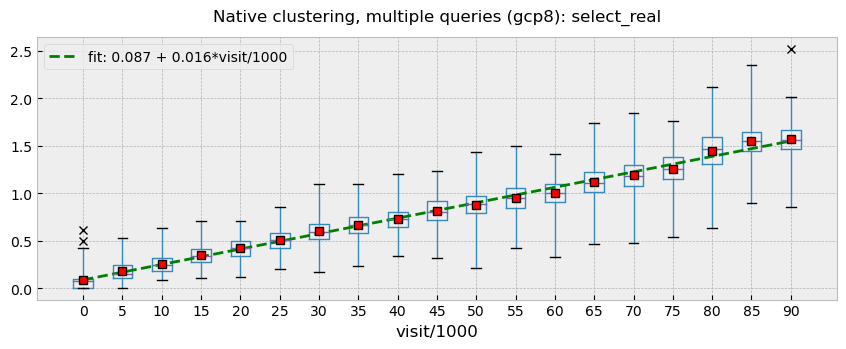

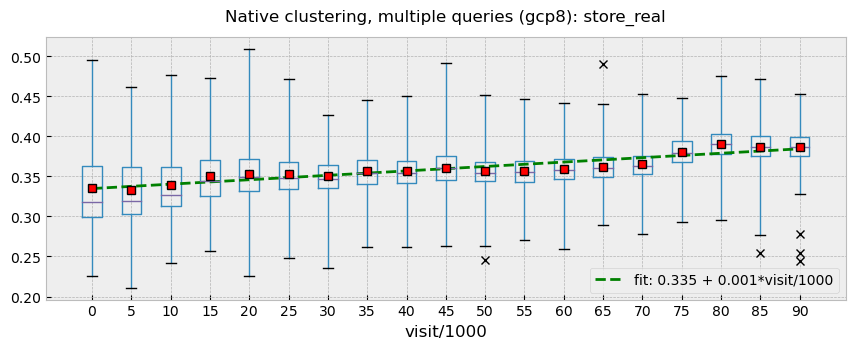

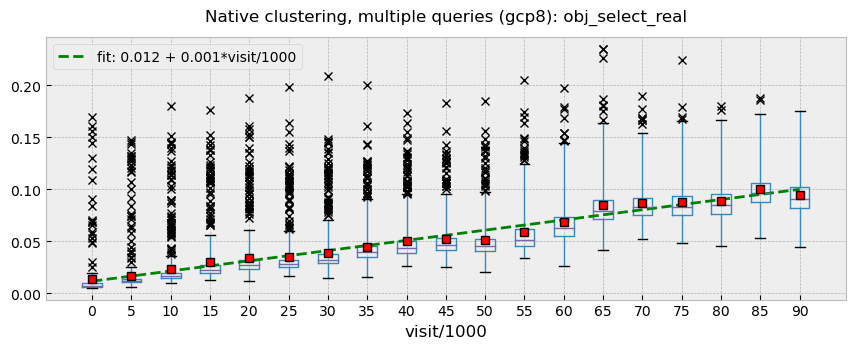

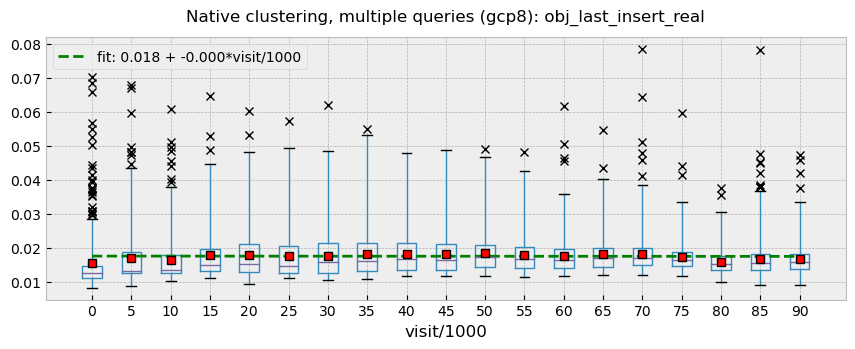

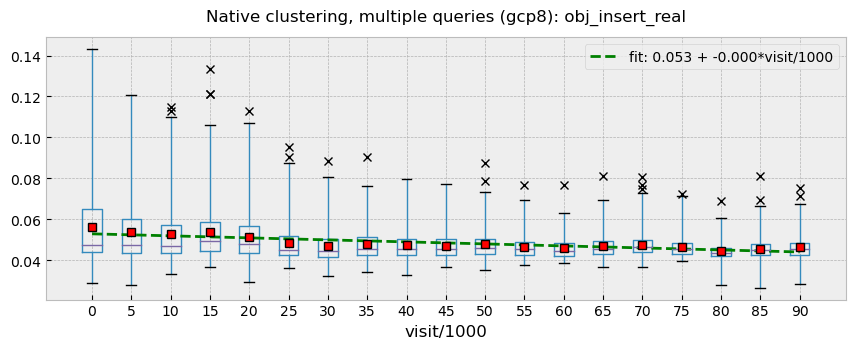

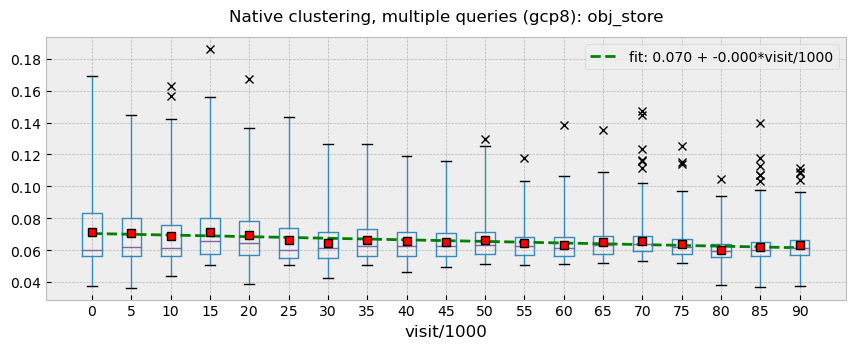

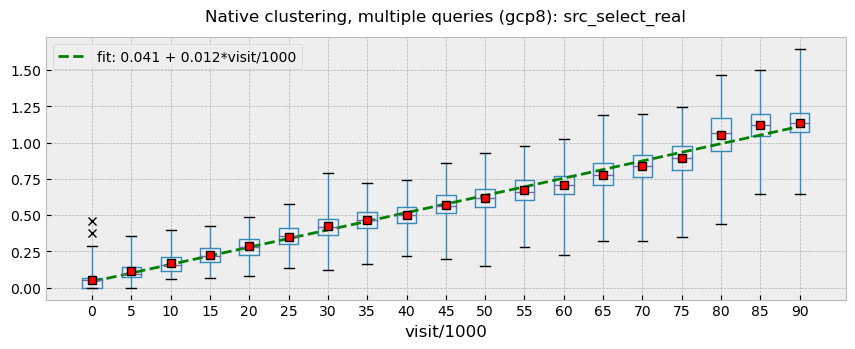

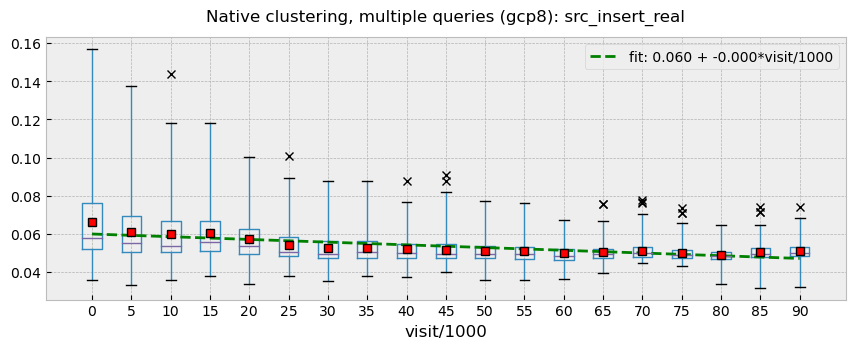

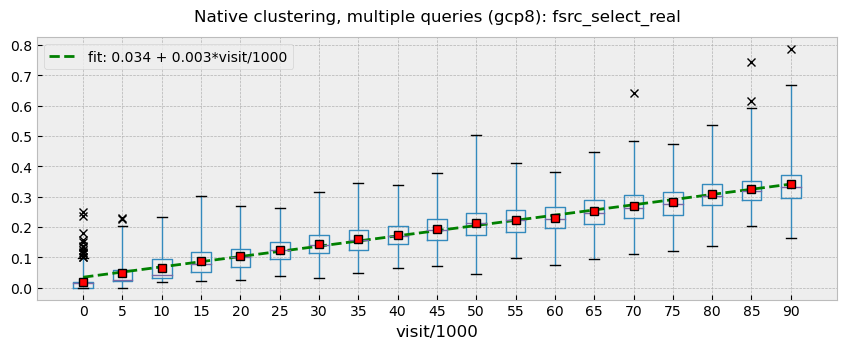

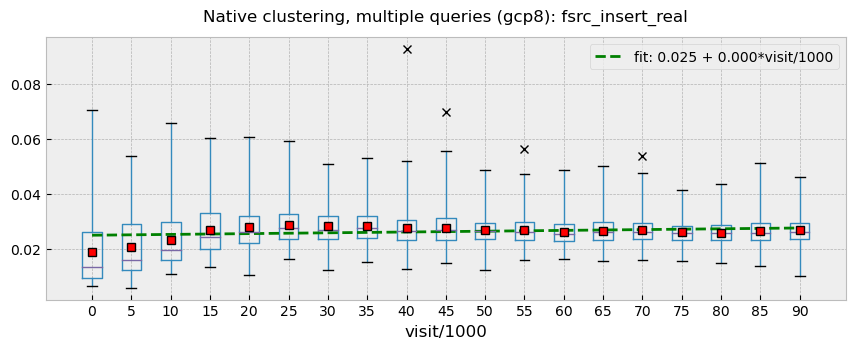

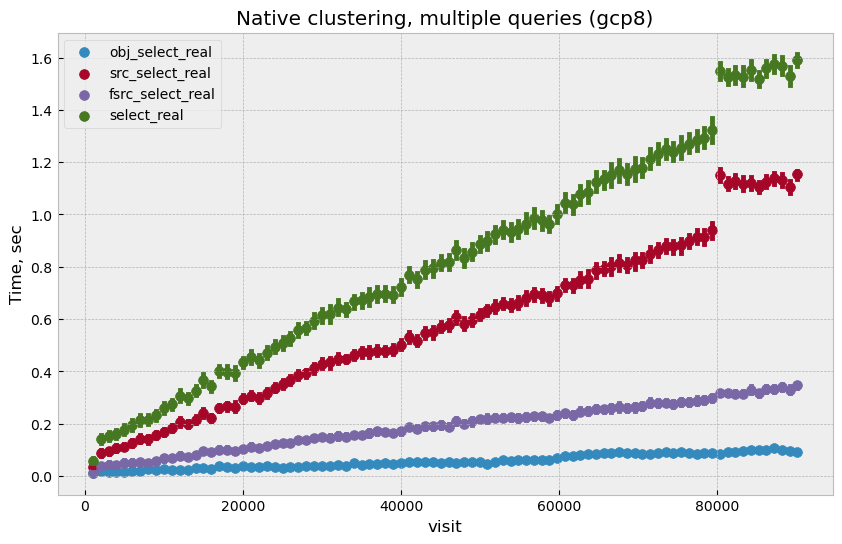

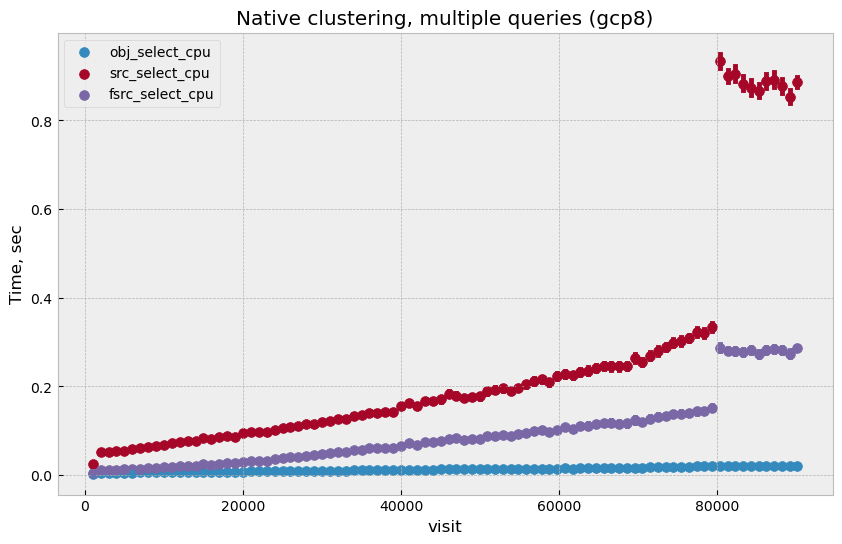

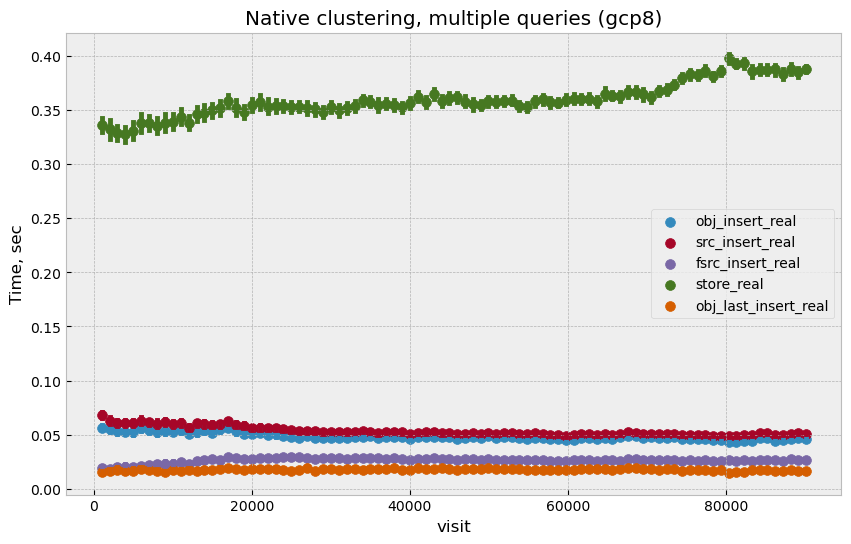

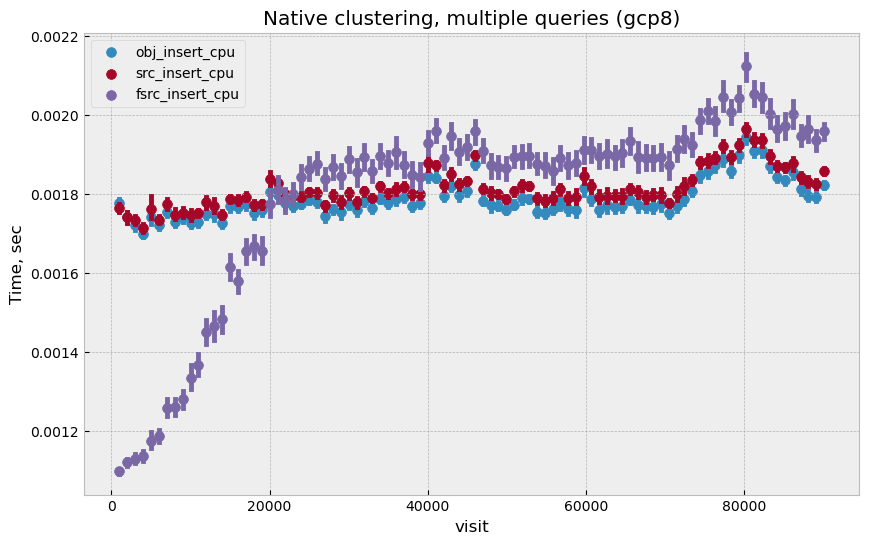

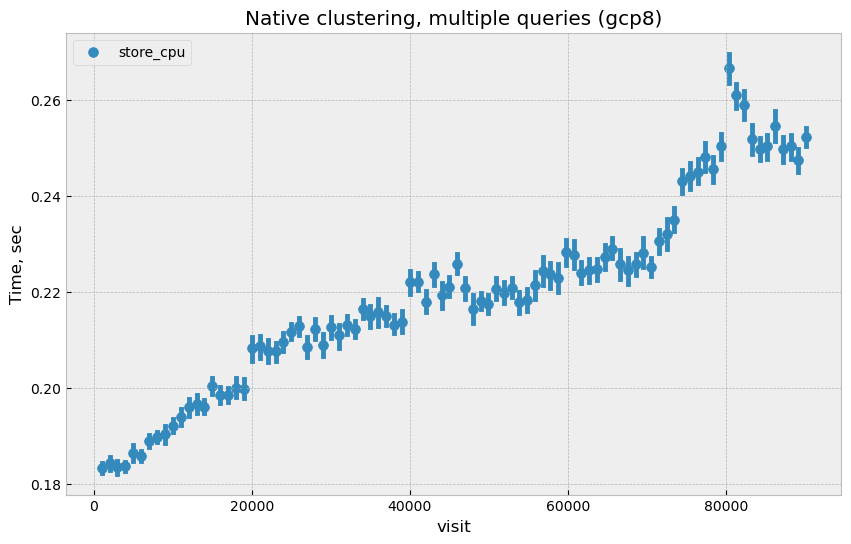

In [18]:
title = "Native clustering, multiple queries (gcp8)"
plots.do_plots_all(df_cass, title, bin=5000, plots=all_plots, whis=whiskers, fit_mode=None, fit_nbins=91);

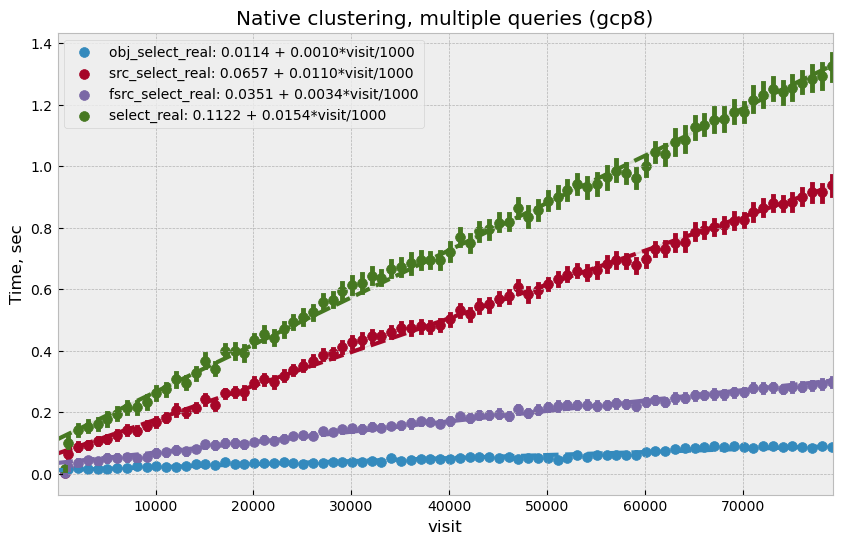

In [20]:
cols = ['obj_select_real', 'src_select_real', 'fsrc_select_real', 'select_real']
plots.plot_fit_times(df_cass[:7999], cols, fit_mode="poly", nbins=80, title=title);